# Syft Duet - Data Scientist 

## PART 1: Connect to a Remote Duet Server

As the Data Scientist, you want to perform data science on data that is sitting in the Data Owner's Duet server in their Notebook.

In order to do this, we must run the code that the Data Owner sends us, which importantly includes their Duet Session ID. The code will look like this, importantly with their real Server ID.

```
import syft as sy
duet = sy.duet('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
```

This will create a direct connection from my notebook to the remote Duet server. Once the connection is established all traffic is sent directly between the two nodes.

Paste the code or Server ID that the Data Owner gives you and run it in the cell below. It will return your Client ID which you must send to the Data Owner to enter into Duet so it can pair your notebooks.


Please do not run ```duet``` blocks from ```Duet_FL_Data_Owner_1_Alice``` and ```Duet_FL_Data_Owner_2_Bob``` "Simultaneously".  
The sequence of runs is:  
* 1. Go to ```Duet_FL_Data_Owner_1_Alice``` file and run its ```duet``` block
* 2. Back to ```Duet_FL_Data_Scientist``` file and run its ```duet1``` block
* 3. Go to ```Duet_FL_Data_Owner_2_Bob``` file and run its ```duet``` block
* 4. Back to ```Duet_FL_Data_Scientist``` file and run  its ```duet2``` block


In [123]:
import syft as sy
#Alice
duet1 = sy.join_duet(loopback=True)

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-218-7-180.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!


/home/fjunyuan/.local/lib/python3.8/site-packages/aiortc/rtcdtlstransport.py:211: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  _openssl_assert(lib.SSL_CTX_use_certificate(ctx, self._cert._x509) == 1)  # type: ignore
/home/fjunyuan/.local/lib/python3.8/site-packages/aiortc/rtcdtlstransport.py:186: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  value=certificate_digest(self._cert._x509),  # type: ignore



♫♫♫ > CONNECTED!


In [124]:
#Bob
duet2 = sy.join_duet(loopback=True)# Part 2: Search for Available Data


🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-218-7-180.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > CONNECTED!


Now you can go back to ```Duet_FL_Data_Owner_1_Alice``` and ```Duet_FL_Data_Owner_2_Bob``` and run the rest of the code there.  
Since everything is finished you can back to here.

# Part 2: Search and point for Available Data


In [125]:
# The data scientist can check the list of searchable data in Data Owner's duet store
duet1.store.pandas

,ID,Tags,Description,object_type
0,<UID: 2585083ae8404693afcb7b6c9315bba3>,[Bob_iris-data],This is a dataset for flower classification of...,<class 'torch.Tensor'>
1,<UID: d5e32a2637b14e3c9e98d99bcb308a13>,[Bob_iris-target],"Labels for flowers: Iris-setosa, Iris-versicol...",<class 'torch.Tensor'>


In [126]:
duet2.store.pandas

,ID,Tags,Description,object_type
0,<UID: f909fc476ad04dfd8ae1d77ced041b08>,[Alice_iris-data],This is a dataset for flower classification of...,<class 'torch.Tensor'>
1,<UID: 9a3f2a91789e406aa0cac295105e9387>,[Alice_iris-target],"Labels for flowers: Iris-setosa, Iris-versicol...",<class 'torch.Tensor'>


Data Scientist wants to use the iris dataset. But (S)He can not directly access to data. (S)He needs a pointer to the data(feature) and a pointer to the target(label) for prediction.

## In this notebook we assume ```data_owner1``` =```Alice``` and ```data_owner2``` = ```Bob```

In [129]:
# Pointers for Alice
data1_ptr = duet1.store[0]#"Alice_iris-data" or "Bob_iris-data" depends on what order you ran it 
target1_ptr = duet1.store[1]#"Alice_iris-target" or "Bob_iris-target"

`data_ptr` is a reference to the iris dataset remotely available on data owner's server.
`target_ptr` is a reference to the iris dataset LABELS remotely available on data owner's server

In [131]:
# Pointers for Bob
data2_ptr = duet2.store[0]
target2_ptr = duet2.store[1]

In [132]:
print(data1_ptr)
print(target1_ptr)
print(data2_ptr)
print(target2_ptr)

## PART 3: Setting up a Model
The model we use is MLP

First, let's create our model for `MLP`. We do this in almost the exact same way as in PyTorch. The main difference is we inherit from sy.Module instead of nn.Module and we need to pass in a variable called torch_ref which we will use internally for any calls that would normally be to torch.

In [133]:
class SyNet(sy.Module):
    def __init__(self, torch_ref):
        #继承父类 sy.Module
        super(SyNet, self).__init__(torch_ref=torch_ref)
        self.layer1 = self.torch_ref.nn.Linear(in_dim, 20)
        self.layer2 = self.torch_ref.nn.Linear(20, 30)
        self.layer3 = self.torch_ref.nn.Linear(30, 30)
        self.out = self.torch_ref.nn.Linear(30, out_dim)

    def forward(self, x):
        x = self.torch_ref.nn.functional.relu(self.layer1(x))
        x = self.torch_ref.nn.functional.relu(self.layer2(x))
        x = self.torch_ref.nn.functional.relu(self.layer3(x))
        output = self.torch_ref.nn.functional.log_softmax(self.out(x), dim=1)
        return output


## PART 4: Perform MLP on Iris dataset
Now the data scientist can perform machine learning on the data that is in the Data Owner's duet server, without the owner having to share his/her data.

### Basic analysis

First the data scientist needs to know some basic information about the dataset.
1. The length of the dataset
2. The input dimension
3. The output dimension

These information have to be explicitly shared by the Data Owner. Let's try to find them in the data description.

In [134]:
print(duet1.store.pandas["Description"][0])
print()
print(duet1.store.pandas["Description"][1])

This is a dataset for flower classification of 80 samples. 4 Features are sepal length (cm),sepal width (cm), petal length (cm), petal width (cm)

Labels for flowers: Iris-setosa, Iris-versicolour, Iris-virginica


In [135]:
print(duet2.store.pandas["Description"][0])
print()
print(duet2.store.pandas["Description"][1])

This is a dataset for flower classification of 70 samples. 4 Features are sepal length (cm),sepal width (cm), petal length (cm), petal width (cm)

Labels for flowers: Iris-setosa, Iris-versicolour, Iris-virginica


In [136]:
#After analysing, let us set data dimension and data size values as global
in_dim = 4
out_dim = 3
n_samples_Alice = 70
n_samples_Bob = 80

### Training

#### 1.Send one copy of the model to each data owner or client 
#### 2.Train them remotely one by one

In [137]:
import torch as th
import numpy as np

#### 1.Send one copy of the model to each data owner or client 

Now we can create a local model by passing our local copy of torch.

In [138]:
base_model = SyNet(torch)

##### Data Owner 1 -- Alice

In [139]:
remote_model1 = base_model.send(duet1)

Let's create an alias for our partner’s torch called `remote_torch` so we can refer to the local torch as torch and any operation we want to do remotely as `remote_torch`. Remember, the return values from `remote_torch` are Pointers, not the real objects. They mostly act the same when using them with other Pointers but they cannot be mixed with local torch objects.  

Then we will get a pointer to our remote model parameters. Then we will set our optimizer. Here, we will be using `Adam optimizer`. `params` is a pointer to the list of parameters. `optim` is a reference to the Adam optimizer which can be used to optimize the remote model.

In [140]:
remote_torch1 = duet1.torch
params1 = remote_model1.parameters()
optim1 = remote_torch1.optim.Adam(params=params1, lr=0.1)

###### Data Owner 2 -- Bob

In [141]:
remote_model2 = base_model.send(duet2)

In [142]:
remote_torch2 = duet2.torch
params2 = remote_model2.parameters()
optim2 = remote_torch2.optim.Adam(params=params2, lr=0.1)

#### Train them remotely one by one

Now we will create our `train` function. It will take few parameters, like the `remote_model`, `torch_ref`, `optim` and `data_ptr` and `target_ptr`.

In [143]:
def train(iterations, model, torch_ref, optim, data_ptr, target_ptr):

    losses = []

    for i in range(iterations):
        
        # 1) erase previous gradients (if they exist)
        optim.zero_grad()
        
        # 2) make a prediction
        output = model(data_ptr)
        
        # 3) calculate how much we missed
        # nll_loss = negative log-liklihood loss
        # if use mse, returns None because our model's output layer uses "nn.functional.log_softmax"
        loss = torch_ref.nn.functional.nll_loss(output, target_ptr.long())
        
        # loss items
        #########################################
        loss_item = loss.item()
        
        #during training keep track of the loss.
        #we need to ask for the loss item from the data owner, because it is training remotely on his machine
        loss_value = loss_item.get(
            reason="To evaluate training progress", 
            request_block=True, 
            timeout_secs=5
        )

        print("Epoch", i, "loss", loss_value)

        losses.append(loss_value)
        #########################################
        
        # 4) figure out which weights caused us to miss
        loss.backward()
        
        # 5) change those weights
        optim.step()

    return losses

###### Data Owner 1 -- Alice

Train on Data Owner 1 data

In [144]:
iteration = 10
losses1 = train(iteration, remote_model1, remote_torch1, optim1, data1_ptr, target1_ptr)

Epoch 0 loss 1.0737802982330322
Epoch 1 loss 1.8612384796142578
Epoch 2 loss 2.5130488872528076
Epoch 3 loss 0.7627922296524048
Epoch 4 loss 0.7989017367362976
Epoch 5 loss 0.7667847871780396
Epoch 6 loss 0.72768634557724
Epoch 7 loss 0.6890068054199219
Epoch 8 loss 0.6652630567550659
Epoch 9 loss 0.6882396340370178


In [145]:
#target1_ptr.get(request_block=True, delete_obj=False)

Text(0.5, 0, 'iteration')

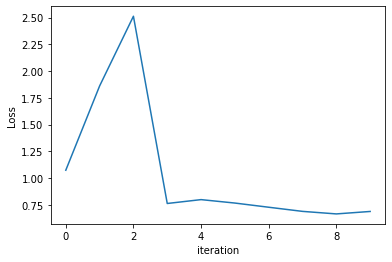

In [146]:
import matplotlib.pyplot as plt
plt.plot(range(iteration), losses1)
plt.ylabel("Loss")
plt.xlabel("iteration")

###### Data Owner 2 -- Bob

Train on Data Owner 2 data

In [147]:
iteration = 10
losses2 = train(iteration, remote_model2, remote_torch2, optim2, data2_ptr, target2_ptr)

Epoch 0 loss 1.1967906951904297
Epoch 1 loss 0.630227267742157
Epoch 2 loss 0.9017127752304077
Epoch 3 loss 0.5787566900253296
Epoch 4 loss 0.5602102875709534
Epoch 5 loss 0.4927288591861725
Epoch 6 loss 0.45493268966674805
Epoch 7 loss 0.3884612023830414
Epoch 8 loss 0.33013519644737244
Epoch 9 loss 0.2769438624382019


Text(0.5, 0, 'iteration')

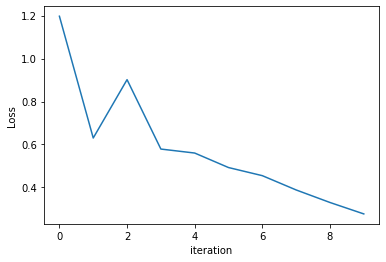

In [148]:
plt.plot(range(iteration), losses2)
plt.ylabel("Loss")
plt.xlabel("iteration")

### Averaging Model Updates

Ideally, there will be a coordinator server with a secure aggreagtor who will get the model updates from different clients and make an aggregation. For the case of simplicity, in this example we will make the Data Sceintist server work as the coordinator.

### Little sanity check!

In [156]:
param1 = remote_model1.parameters().get(request_block=True)
param2 = remote_model2.parameters().get(request_block=True)

print("Base Model parameters:")
print(base_model.parameters())
#weights, bias

Base Model parameters:
[Parameter containing:
tensor([[ 0.4920, -0.0365, -0.4415,  0.1528],
        [ 0.4176,  0.1077, -0.3733,  0.1945],
        [-0.0434,  0.1223,  0.0178, -0.2859],
        [-0.1380, -0.4091,  0.0014,  0.4134],
        [ 0.3687,  0.0507,  0.4513, -0.4377],
        [-0.1855,  0.0480, -0.4581, -0.2016],
        [ 0.3129, -0.3290,  0.1050, -0.4532],
        [-0.2686, -0.3616, -0.3187,  0.0046],
        [-0.4551,  0.3928,  0.3300, -0.1806],
        [ 0.1425,  0.4208, -0.1036, -0.4148],
        [ 0.4731,  0.2387, -0.0133,  0.0024],
        [ 0.4032,  0.3590, -0.1246,  0.1719],
        [-0.2105, -0.2670, -0.2767, -0.1688],
        [-0.0371,  0.0421, -0.3847,  0.3509],
        [ 0.1870,  0.4645, -0.0717, -0.4649],
        [-0.0799, -0.2294,  0.3206, -0.0140],
        [-0.4798, -0.1110, -0.0200,  0.1772],
        [ 0.2586,  0.2619, -0.0745, -0.0618],
        [ 0.2703, -0.3582,  0.1549,  0.2104],
        [-0.4078,  0.3210,  0.1967,  0.4145]], requires_grad=True), Parameter co

In [157]:
print("Remote model1 parameters:")
print(param1)

Remote model1 parameters:
[Parameter containing:
tensor([[ 0.1302, -0.4009, -0.7935, -0.1886],
        [ 0.0487, -0.2635, -0.7329, -0.1551],
        [-0.0434,  0.1223,  0.0178, -0.2859],
        [-0.1380, -0.4091,  0.0014,  0.4134],
        [-0.2216, -0.5422, -0.1289, -1.0081],
        [-0.1855,  0.0480, -0.4581, -0.2016],
        [ 0.2879, -0.3886,  0.1780, -0.3081],
        [-0.2686, -0.3616, -0.3187,  0.0046],
        [-0.4551,  0.3928,  0.3300, -0.1806],
        [-0.2763,  0.0020, -0.5224, -0.8336],
        [ 0.0921, -0.1488, -0.3658, -0.3189],
        [ 0.0949,  0.0432, -0.4005, -0.0719],
        [-0.2105, -0.2670, -0.2767, -0.1688],
        [-0.0371,  0.0421, -0.3847,  0.3509],
        [-0.1716,  0.1030, -0.4189, -0.8018],
        [-0.4986, -0.6482, -0.0982, -0.4327],
        [-0.4798, -0.1110, -0.0200,  0.1772],
        [-0.0856, -0.0850, -0.4058, -0.3794],
        [-0.3152, -0.9477, -0.2191, -0.1512],
        [-0.7937, -0.0646, -0.1851,  0.0412]], requires_grad=True), Parameter

In [158]:
print("Remote model2 parameters:")
print(param2)

Remote model2 parameters:
[Parameter containing:
tensor([[ 0.0178, -0.5114, -0.9144, -0.3233],
        [-0.1618, -0.4166, -1.0175, -0.4378],
        [-0.3976, -0.1940, -0.2478, -0.5188],
        [-0.1380, -0.4091,  0.0014,  0.4134],
        [ 0.0227, -0.0133, -0.2915, -1.1410],
        [-0.1855,  0.0480, -0.4581, -0.2016],
        [-0.0667, -0.7287, -0.0245, -0.1607],
        [-0.2686, -0.3616, -0.3187,  0.0046],
        [-0.4551,  0.3928,  0.3300, -0.1806],
        [ 0.1730,  0.7135, -0.4616, -1.0475],
        [ 0.2288,  0.1352, -0.8260, -0.7280],
        [-0.1607, -0.1656, -0.7050, -0.2117],
        [-0.2105, -0.2670, -0.2767, -0.1688],
        [-0.0371,  0.0421, -0.3847,  0.3509],
        [-0.3992, -0.1279, -0.5426, -0.7000],
        [-0.4986, -0.6482, -0.0982, -0.4327],
        [-0.4798, -0.1110, -0.0200,  0.1772],
        [-0.3740, -0.3092, -0.7598, -0.7096],
        [-0.2254, -0.5938, -0.3903, -0.3451],
        [-0.4078,  0.3210,  0.1967,  0.4145]], requires_grad=True), Parameter

As you can see, the remote model paramter values are different from the base model paramter values. That means the remote copies of our base model got trained and updated.

In [159]:
remote_model1_updates = remote_model1.get(
    request_block=True
).state_dict()

OrderedDict([('layer1.weight', tensor([[ 0.1302, -0.4009, -0.7935, -0.1886],
        [ 0.0487, -0.2635, -0.7329, -0.1551],
        [-0.0434,  0.1223,  0.0178, -0.2859],
        [-0.1380, -0.4091,  0.0014,  0.4134],
        [-0.2216, -0.5422, -0.1289, -1.0081],
        [-0.1855,  0.0480, -0.4581, -0.2016],
        [ 0.2879, -0.3886,  0.1780, -0.3081],
        [-0.2686, -0.3616, -0.3187,  0.0046],
        [-0.4551,  0.3928,  0.3300, -0.1806],
        [-0.2763,  0.0020, -0.5224, -0.8336],
        [ 0.0921, -0.1488, -0.3658, -0.3189],
        [ 0.0949,  0.0432, -0.4005, -0.0719],
        [-0.2105, -0.2670, -0.2767, -0.1688],
        [-0.0371,  0.0421, -0.3847,  0.3509],
        [-0.1716,  0.1030, -0.4189, -0.8018],
        [-0.4986, -0.6482, -0.0982, -0.4327],
        [-0.4798, -0.1110, -0.0200,  0.1772],
        [-0.0856, -0.0850, -0.4058, -0.3794],
        [-0.3152, -0.9477, -0.2191, -0.1512],
        [-0.7937, -0.0646, -0.1851,  0.0412]])), ('layer1.bias', tensor([-0.3648, -0.1909, -0.1

In [160]:
remote_model1.get(
    request_block=True
).parameters()

[Parameter containing:
 tensor([[ 0.1302, -0.4009, -0.7935, -0.1886],
         [ 0.0487, -0.2635, -0.7329, -0.1551],
         [-0.0434,  0.1223,  0.0178, -0.2859],
         [-0.1380, -0.4091,  0.0014,  0.4134],
         [-0.2216, -0.5422, -0.1289, -1.0081],
         [-0.1855,  0.0480, -0.4581, -0.2016],
         [ 0.2879, -0.3886,  0.1780, -0.3081],
         [-0.2686, -0.3616, -0.3187,  0.0046],
         [-0.4551,  0.3928,  0.3300, -0.1806],
         [-0.2763,  0.0020, -0.5224, -0.8336],
         [ 0.0921, -0.1488, -0.3658, -0.3189],
         [ 0.0949,  0.0432, -0.4005, -0.0719],
         [-0.2105, -0.2670, -0.2767, -0.1688],
         [-0.0371,  0.0421, -0.3847,  0.3509],
         [-0.1716,  0.1030, -0.4189, -0.8018],
         [-0.4986, -0.6482, -0.0982, -0.4327],
         [-0.4798, -0.1110, -0.0200,  0.1772],
         [-0.0856, -0.0850, -0.4058, -0.3794],
         [-0.3152, -0.9477, -0.2191, -0.1512],
         [-0.7937, -0.0646, -0.1851,  0.0412]], requires_grad=True),
 Parameter cont

In [161]:
remote_model2_updates = remote_model2.get(
    request_block=True
).state_dict()

In [153]:
from collections import OrderedDict

Let's do the aggregation of the weights. In this example, we will just calculate the average of corresponding weights from each model.  
Here we have ```layer1.weight```, ```layer1.bias```, ```layer2.weight```, ```layer2.bias```, ```layer3.weight```, ```layer3.bias```

In [165]:
remote_model1_updates["layer1.bias"]

tensor([-0.3648, -0.1909, -0.1935, -0.1045, -0.8293, -0.3833,  0.3220, -0.2896,
        -0.3121, -0.4337, -0.6202, -0.4688,  0.4153, -0.3124, -0.0017, -0.6961,
         0.4951,  0.1291, -0.8409, -0.8584])

In [ ]:
Aggrigator: FedAvg()

In [154]:
avg_updates = OrderedDict()
avg_updates["linear.weight"] = (
    remote_model1_updates["linear.weight"] + remote_model2_updates["linear.weight"]
) / 2
avg_updates["linear.bias"] = (
    remote_model1_updates["linear.bias"] + remote_model2_updates["linear.bias"]
) / 2

print(avg_updates)

KeyError: 'linear.weight'

### Load aggregated weights

In [28]:
combined_model = SyNet(torch)

In [29]:
combined_model.load_state_dict(avg_updates)

In [30]:
del avg_updates, remote_model1_updates, remote_model2_updates

In [31]:
test_data = th.FloatTensor(np.array([17, 25, 32, 50, 80]).reshape(-1, 1))
test_target = th.FloatTensor(np.array([12, 15, 20, 30, 50]).reshape(-1, 1))

In [32]:
preds = []
with torch.no_grad():
    for i in range(len(test_data)):
        sample = test_data[i]
        y_hat = combined_model(sample)

        print(f"Prediction: {y_hat.item()} Ground Truth: {test_target[i].item()}")
        preds.append(y_hat)

Prediction: 11.230474472045898 Ground Truth: 12.0
Prediction: 15.794936180114746 Ground Truth: 15.0
Prediction: 19.78883934020996 Ground Truth: 20.0
Prediction: 30.05887794494629 Ground Truth: 30.0
Prediction: 47.17560577392578 Ground Truth: 50.0


In [33]:
preds = []
with torch.no_grad():
    for i in range(len(test_data)):
        sample = test_data[i]
        y_hat = base_model(sample)

        print(f"Prediction: {y_hat.item()} Ground Truth: {test_target[i].item()}")
        preds.append(y_hat)

Prediction: -5.287985801696777 Ground Truth: 12.0
Prediction: -8.065629959106445 Ground Truth: 15.0
Prediction: -10.496068954467773 Ground Truth: 20.0
Prediction: -16.74576759338379 Ground Truth: 30.0
Prediction: -27.16193389892578 Ground Truth: 50.0


## Comparison to classical linear regression on centralised data

In [34]:
import torch
import numpy as np

in_dim = 1
out_dim = 1


class ClassicalLR(torch.nn.Module):
    def __init__(self, torch):
        super(ClassicalLR, self).__init__()
        self.linear = torch.nn.Linear(in_dim, out_dim)

    def forward(self, x):
        x = self.linear(x)
        return x


classical_model = ClassicalLR(torch)

In [35]:
data = torch.FloatTensor(
    np.array([5, 15, 25, 35, 45, 55, 60, 65, 75, 85, 95]).reshape(-1, 1)
)
target = torch.FloatTensor(
    np.array([5, 10, 15, 22, 30, 38, 35, 40, 45, 55, 60]).reshape(-1, 1)
)

In [36]:
def classic_train(iterations, model, torch, optim, data, target, criterion):

    losses = []

    for i in range(iterations):

        optim.zero_grad()

        output = model(data)

        loss = criterion(output, target)

        loss_item = loss.item()

        if i % 10 == 0:
            print("Epoch", i, "loss", loss_item)

        losses.append(loss_item)

        loss.backward()

        optim.step()

    return losses

In [37]:
params = classical_model.parameters()
optim = torch.optim.Adam(params=params, lr=0.1)
criterion = torch.nn.MSELoss()

In [38]:
iteration = 100
losses = classic_train(
    iteration, classical_model, torch, optim, data, target, criterion
)

Epoch 0 loss 155.32406616210938
Epoch 10 loss 5.576186656951904
Epoch 20 loss 10.015868186950684
Epoch 30 loss 6.7609357833862305
Epoch 40 loss 3.4427340030670166
Epoch 50 loss 3.3968307971954346
Epoch 60 loss 3.2446601390838623
Epoch 70 loss 3.108318567276001
Epoch 80 loss 3.0627920627593994
Epoch 90 loss 3.031777858734131


In [39]:
test_data = th.FloatTensor(np.array([17, 25, 32, 50, 80]).reshape(-1, 1))
test_target = th.FloatTensor(np.array([12, 15, 20, 30, 50]).reshape(-1, 1))

In [40]:
preds = []
with torch.no_grad():
    for i in range(len(test_data)):
        sample = test_data[i]
        y_hat = classical_model(sample)

        print(f"Prediction: {y_hat.item()} Ground Truth: {test_target[i].item()}")
        preds.append(y_hat)

Prediction: 10.930621147155762 Ground Truth: 12.0
Prediction: 15.931267738342285 Ground Truth: 15.0
Prediction: 20.306833267211914 Ground Truth: 20.0
Prediction: 31.55828857421875 Ground Truth: 30.0
Prediction: 50.31071472167969 Ground Truth: 50.0
